# Response time minimization - Møre and Romsdal police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.


#### Møre and Romsdal police district
The district covers an area of ​​15,099 square kilometers with 266,274 inhabitants spread over the following 26 municipalities: Vanylven, Sande, Herøy, Ulstein, Hareid, Volda, Ørsta, Fjord, Stranda, Sykkylven, Sula, Giske, Ålesund, Vestnes, Rauma, Aukra , Molde, Hustadvika, Averøy, Kristiansund, Gjemnes, Tingvoll, Sunndal, Surnadal, Smøla and Aure.

In [67]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-28T19:51:09.914426+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

osmnx     : 1.9.1
matplotlib: 3.8.3
numpy     : 1.26.4
geopandas : 0.14.3
pandana   : 0.7
pandas    : 2.2.1



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [69]:
### Load road network from file
MoreRomsdal_filepath = "../data/MoreRomsdal/MoreRomsdalDriveImputed.graphml" # with travel time attribute
MoreRomsdal_graph = ox.load_graphml(MoreRomsdal_filepath) # originally in WGS84 (EPSG:4326)

In [70]:
MoreRomsdal_graph = ox.projection.project_graph(MoreRomsdal_graph) # project to local UTM zone
print(f"Type of MoreRomsdal_graph: {type(MoreRomsdal_graph)}")
print(f"CRS of MoreRomsdal_graph:  {MoreRomsdal_graph.graph['crs']}")

# # plot graph
# fig, ax = ox.plot_graph(MoreRomsdal_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of MoreRomsdal_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of MoreRomsdal_graph:  EPSG:32632


Convert MultiDiGraph to node and edge GeoDataFrames.

In [71]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(MoreRomsdal_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid   ref           name    highway maxspeed  \
u          v          key                                                      
24492641   5086232880 0    43366493  5972  Jordmorbrauta  secondary       80   
5086232880 24492641   0    43366493  5972  Jordmorbrauta  secondary       80   

                           oneway reversed  length  \
u          v          key                            
24492641   5086232880 0     False     True 202.381   
5086232880 24492641   0     False    False 202.381   

                                                                    geometry  \
u          v          key                                                      
24492641   5086232880 0    LINESTRING (357418.463 6945967.187, 357406.330...   
5086232880 24492641   0    LINESTRING (357224.306 6945995.940, 357235.467...   

                           speed_kph  travel_time bridge lanes tunnel  \
u          v          key                                               
24492641   5086232880 0       80.000        9.100    NaN   NaN    NaN   
5086232880 24492641   0       80.000        9.100    NaN   NaN    NaN   

                          junction width access  
u          v          key                        
24492641   5086232880 0        NaN   NaN    NaN  
5086232880 24492641   0        NaN   NaN    NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [72]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid   ref           name    highway maxspeed  \
u          v          key                                                      
24492641   5086232880 0    43366493  5972  Jordmorbrauta  secondary       80   
5086232880 24492641   0    43366493  5972  Jordmorbrauta  secondary       80   

                           oneway reversed  length  \
u          v          key                            
24492641   5086232880 0     False     True 202.381   
5086232880 24492641   0     False    False 202.381   

                                                                    geometry  \
u          v          key                                                      
24492641   5086232880 0    LINESTRING (357418.463 6945967.187, 357406.330...   
5086232880 24492641   0    LINESTRING (357224.306 6945995.940, 357235.467...   

                           speed_kph  travel_time bridge lanes tunnel  \
u          v          key                                               
24492641   5086232880 0      104.525        6.970    NaN   NaN    NaN   
5086232880 24492641   0      104.525        6.970    NaN   NaN    NaN   

                          junction width access  
u          v          key                        
24492641   5086232880 0        NaN   NaN    NaN  
5086232880 24492641   0        NaN   NaN    NaN

In [73]:
# recombining nodes and increased edges to MultiDiGraph format
MoreRomsdal_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [74]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
MoreRomsdal_polygon_path = "../data/MoreRomsdal/MoreRomsdalCombinedPolygon.geojson"
MoreRomsdal_polygon_gdf = gpd.read_file(MoreRomsdal_polygon_path)
MoreRomsdal_polygon_gdf = MoreRomsdal_polygon_gdf.to_crs(MoreRomsdal_graph.graph['crs']) # convert to same CRS as the road network

In [75]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/MoreRomsdal/MoreRomsdalPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(MoreRomsdal_graph.graph['crs']) # convert to same CRS as the road network

In [76]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  20075006908750           4   
1  20075006909000           2   

                                            geometry  
0  POLYGON ((320693.748 6877609.086, 320670.659 6...  
1  POLYGON ((320670.659 6877857.372, 320647.569 6...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [77]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1500, max_range=1550) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1350, max_range=1450) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 1410. Target range [1350, 1450], using population multiplier: 0.008347656250000002


id  population  \
5103  20455006957750         584   
5152  20445006958000         590   
5080  20452506957750         498   

                                               geometry  num_points  
5103  POLYGON ((353903.439 6929796.686, 353880.253 6...           5  
5152  POLYGON ((352886.842 6929952.296, 352863.656 6...           5  
5080  POLYGON ((353655.085 6929773.501, 353631.900 6...           4

In [78]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (320301.064 6890329.948)
1  POINT (320240.949 6890587.007)
2  POINT (349268.447 6894089.649)

In [79]:
# print(f"Number of nodes: {len(nodes)}")
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=1.5e-11, simplification_tolerance=5.0, plot_results=False)

Density: Min: 4.329e-92 | Median: 1.504e-12 | Mean: 3.386e-11 | Max: 6.980e-10


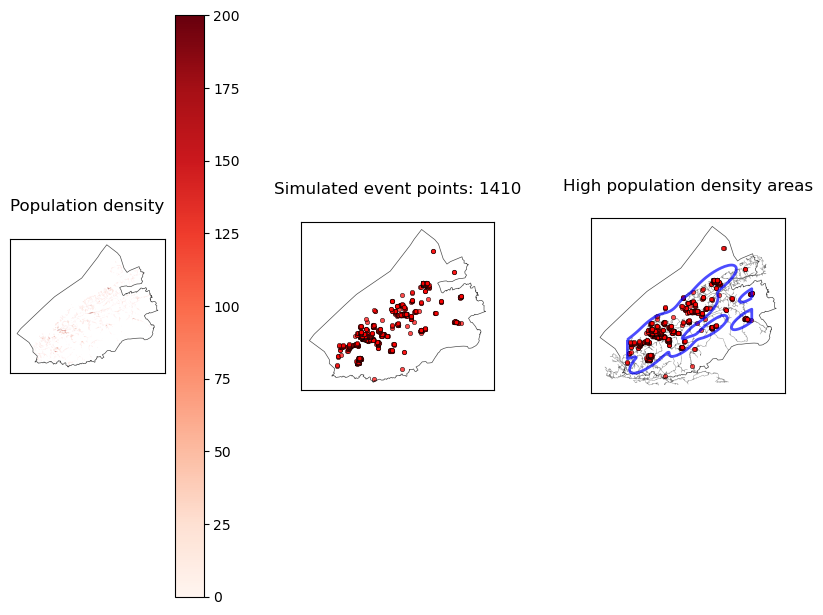

In [80]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(MoreRomsdal_polygon_gdf, population_gdf, 
                                                event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [81]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/MoreRomsdal/MoreRomsdalNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count   lon    lat highway  \
osmid                                                                  
24492641   6945967.187 357418.463             1 6.221 62.617     NaN   
5086232880 6945995.940 357224.306             4 6.217 62.617     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
24492641    POINT (357418.463 6945967.187)                 0.000   
5086232880  POINT (357224.306 6945995.940)                 0.000   

            betweenness_centrality  
osmid                               
24492641                     0.000  
5086232880               86386.000

### 2.2 Sample candidate points and filter out best candidate points

In [82]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 17913, nr of police car nodes: 100


y          x  street_count   lon    lat highway  \
osmid                                                                  
7389963083 6926327.050 364137.649             3 6.367 62.443     NaN   
7023239925 6916240.976 338554.063             1 5.882 62.343     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
7389963083  POINT (364137.649 6926327.050)                 0.000   
7023239925  POINT (338554.063 6916240.976)                 0.000   

            betweenness_centrality  
osmid                               
7389963083             1711571.000  
7023239925                   0.000

Input nr of car nodes: 100
Remaining nr of car nodes: 80, after discarding the 20 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


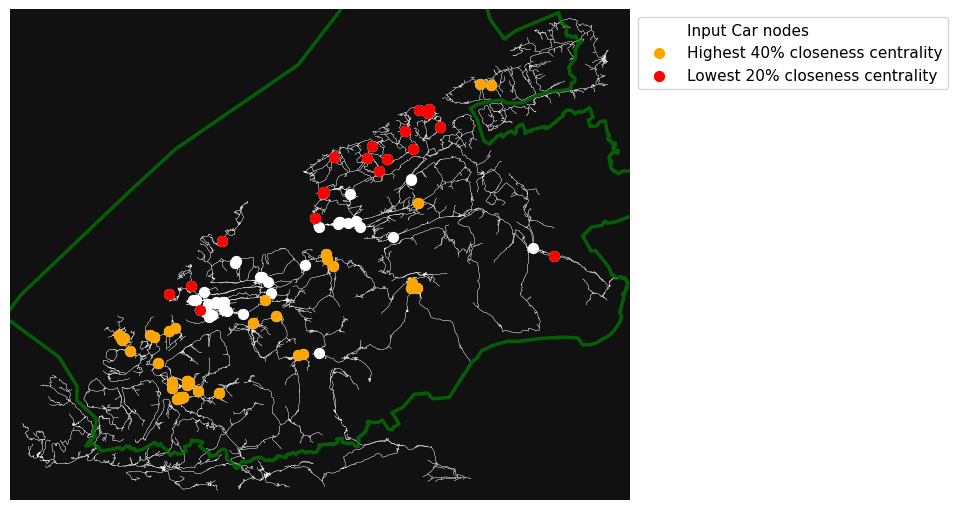

In [83]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=MoreRomsdal_polygon_gdf, 
                    top_percent=0.4, bottom_percent=0.20, input_graph=MoreRomsdal_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 80
Remaining nr of car nodes: 56, after discarding the 24 (30%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


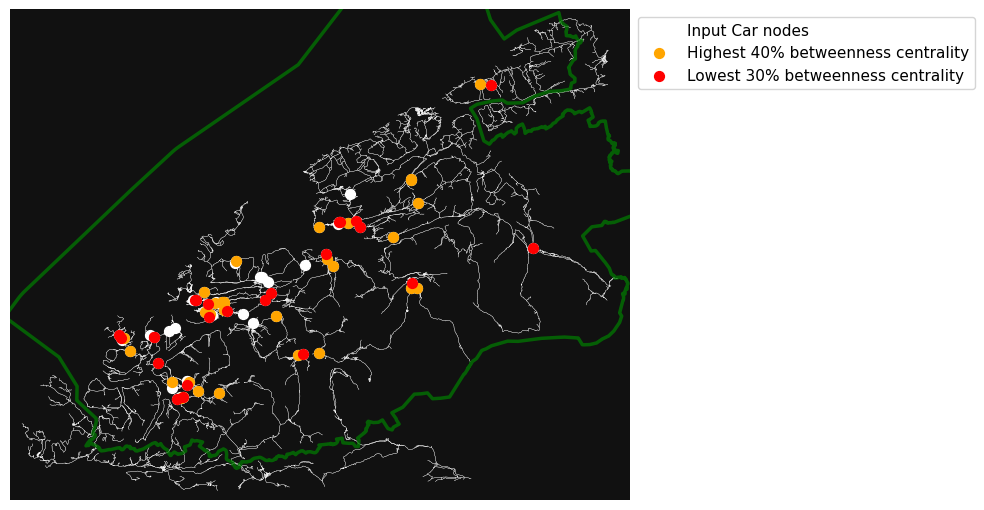

In [84]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=MoreRomsdal_polygon_gdf, 
                        top_percent=0.4, bottom_percent=0.30, input_graph=MoreRomsdal_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 56
Remaining nr of car nodes: 18, after removing the 38 nodes that are within 8000 m of each other



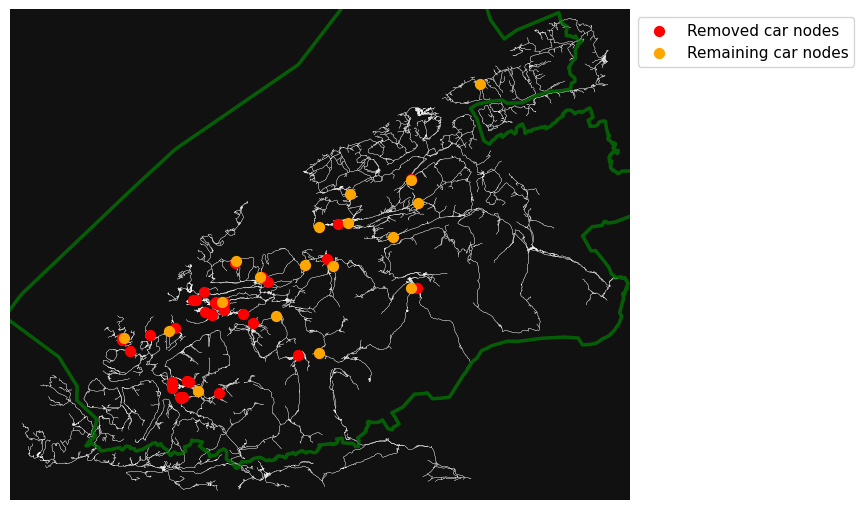

In [85]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=MoreRomsdal_polygon_gdf, 
                        min_distance=8000, input_graph=MoreRomsdal_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [86]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

Since this graph happens to be disconnected we need to include an additional step to separate the connected components. Then we can compute the travel time for each component separately avoiding invalid travel times between nodes that are not connected.

Number of connected components: 3
Number of nodes in component 0: 10810
Number of nodes in component 1: 6038
Number of nodes in component 2: 1065
Total number of nodes in all components: 17913


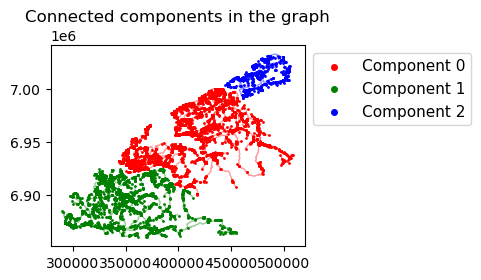

In [87]:
# find connected components
connected_components = utilityModule.find_connected_components(MoreRomsdal_graph, verbose=True, plot=True)

In [88]:
# convert northern and southern graphs to GeoDataFrames
nodes_north, edges_north = ox.graph_to_gdfs(connected_components[2], nodes=True, edges=True)
nodes_south, edges_south = ox.graph_to_gdfs(connected_components[1], nodes=True, edges=True)
nodes_mid, edges_mid = ox.graph_to_gdfs(connected_components[0], nodes=True, edges=True)

# reset index of edges
edges_north = edges_north.reset_index()
edges_south = edges_south.reset_index()
edges_mid = edges_mid.reset_index()
edges_north.head(1)

u           v  key      osmid    name      highway maxspeed  \
0  7252580353  7252580242    0  170846304  Stølan  residential       30   

   oneway reversed  length                                           geometry  \
0   False     True  38.054  LINESTRING (503260.129 7018337.542, 503265.290...   

   speed_kph  travel_time  ref bridge lanes junction tunnel width  
0     30.000        4.600  NaN    NaN   NaN      NaN    NaN   NaN

In [89]:
# create network with pandana
MoreRomsdal_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# create pandana network for northern and southern graphs
MoreRomsdal_network_pdna_north = pdna.Network(node_x=nodes_north['x'], node_y=nodes_north['y'], 
                                     edge_from=edges_north['u'], edge_to=edges_north['v'], 
                                     edge_weights=edges_north[["length", "travel_time"]], twoway=True)

MoreRomsdal_network_pdna_south = pdna.Network(node_x=nodes_south['x'], node_y=nodes_south['y'],
                                        edge_from=edges_south['u'], edge_to=edges_south['v'], 
                                        edge_weights=edges_south[["length", "travel_time"]], twoway=True)

MoreRomsdal_network_pdna_mid = pdna.Network(node_x=nodes_mid['x'], node_y=nodes_mid['y'],
                                        edge_from=edges_mid['u'], edge_to=edges_mid['v'], 
                                        edge_weights=edges_mid[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of MoreRomsdal_network_pdna: {type(MoreRomsdal_network_pdna)}")
print(f"Network nodes:")
MoreRomsdal_network_pdna.nodes_df.head(1)

type of MoreRomsdal_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                          
24492641 357418.463 6945967.187

In [90]:
print(f"Network edges: ")
MoreRomsdal_network_pdna.edges_df.head(1)

Network edges: 


from          to  length  travel_time
0  24492641  5086232880 202.381        6.970

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [91]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = MoreRomsdal_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry   nearest_node          x           y
0  POINT (320301.064 6890329.948) 5783875368.000 320265.653 6890340.856
1  POINT (320240.949 6890587.007) 5783893472.000 320393.804 6890546.647

Length of original event_points_gdf: 1387
Length of northern event_points_gdf: 2
Length of southern event_points_gdf: 288
Length of middle event_points_gdf: 1097


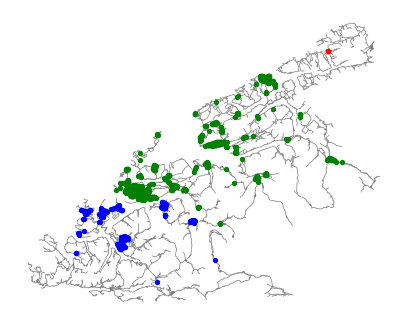

In [92]:
# split event_points_gdf into northern part and southern part by checking if the nearest node is in northern or southern graph
event_points_gdf_north = event_points_gdf[event_points_gdf['nearest_node'].isin(nodes_north.index)]
event_points_gdf_south = event_points_gdf[event_points_gdf['nearest_node'].isin(nodes_south.index)]
event_points_gdf_mid = event_points_gdf[event_points_gdf['nearest_node'].isin(nodes_mid.index)]

# verify the lengths of the split dataframes compared to the original
print(f"Length of original event_points_gdf: {len(event_points_gdf)}")
print(f"Length of northern event_points_gdf: {len(event_points_gdf_north)}")
print(f"Length of southern event_points_gdf: {len(event_points_gdf_south)}")
print(f"Length of middle event_points_gdf: {len(event_points_gdf_mid)}")

# plot the event points in the northern and southern parts in different colors
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
edges_north.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
edges_south.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
edges_mid.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
event_points_gdf_north.plot(ax=ax, color='red', markersize=8)
event_points_gdf_south.plot(ax=ax, color='blue', markersize=8)
event_points_gdf_mid.plot(ax=ax, color='green', markersize=8)
# plt.title("Event points in northern and southern parts")
plt.axis("off"); plt.show()

In [93]:
# car_nodes_gdf_filtered.head(2)
nodes_north.head(2)

y          x  street_count   lon    lat highway  \
osmid                                                                  
7252580353 7018337.542 503260.129             3 9.065 63.294     NaN   
7252580242 7018307.527 503283.516             3 9.065 63.294     NaN   

                                  geometry  
osmid                                       
7252580353  POINT (503260.129 7018337.542)  
7252580242  POINT (503283.516 7018307.527)

In [94]:
# reset index so we have 1 header row and not 2
nodes_mid.reset_index(drop=False, inplace=True)
nodes_south.reset_index(drop=False, inplace=True)
nodes_mid.head(2)

osmid           y          x  street_count   lon    lat highway  \
0    24492641 6945967.187 357418.463             1 6.221 62.617     NaN   
1  5086232880 6945995.940 357224.306             4 6.217 62.617     NaN   

                         geometry  
0  POINT (357418.463 6945967.187)  
1  POINT (357224.306 6945995.940)

With only 2 event points in the small northern graph, we ignore part north from the analysis for simplicity.

Length of original car_nodes_gdf: 18
Length of mid car_nodes_gdf: 13
Length of southern car_nodes_gdf: 4


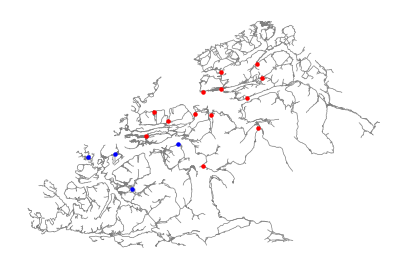

In [95]:
# split car_nodes_gdf into mid part and southern part by checking if the nearest node is in mid or southern graph
car_nodes_gdf_mid = car_nodes_gdf_filtered[car_nodes_gdf_filtered['osmid'].isin(nodes_mid['osmid'])]
car_nodes_gdf_south = car_nodes_gdf_filtered[car_nodes_gdf_filtered['osmid'].isin(nodes_south['osmid'])]

# verify the lengths of the split dataframes compared to the original
print(f"Length of original car_nodes_gdf: {len(car_nodes_gdf_filtered)}")
print(f"Length of mid car_nodes_gdf: {len(car_nodes_gdf_mid)}")
print(f"Length of southern car_nodes_gdf: {len(car_nodes_gdf_south)}")

# plot the car nodes in the mid and southern parts in different colors
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
edges_mid.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
edges_south.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
car_nodes_gdf_mid.plot(ax=ax, color='red', markersize=5)
car_nodes_gdf_south.plot(ax=ax, color='blue', markersize=5)
# plt.title("Car nodes in mid and southern parts")
plt.axis("off"); plt.show()

In [96]:
# Get list of nearest node ids for event locations
event_nodes_pdna = MoreRomsdal_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = MoreRomsdal_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([5784445533, 7389961200, 7036804551, 5849199905, 6637521737],
      dtype=int64)

In [97]:
# Get list of nearest node ids for event locations
event_nodes_pdna_mid = MoreRomsdal_network_pdna_mid.get_node_ids(x_col=event_points_gdf_mid.geometry.x, y_col=event_points_gdf_mid.geometry.y).values
event_nodes_pdna_south = MoreRomsdal_network_pdna_south.get_node_ids(x_col=event_points_gdf_south.geometry.x, y_col=event_points_gdf_south.geometry.y).values
event_nodes_pdna_mid[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna_mid = MoreRomsdal_network_pdna_mid.get_node_ids(x_col=car_nodes_gdf_mid.x, y_col=car_nodes_gdf_mid.y).values
car_nodes_pdna_south = MoreRomsdal_network_pdna_south.get_node_ids(x_col=car_nodes_gdf_south.x, y_col=car_nodes_gdf_south.y).values
car_nodes_pdna[:5]

array([5784445533, 7389961200, 7036804551, 5849199905, 6637521737],
      dtype=int64)

In [98]:
# # Plot overview of Car nodes and Event nodes
# fig, ax = ox.plot_graph(MoreRomsdal_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
# ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
# ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
# plt.show()

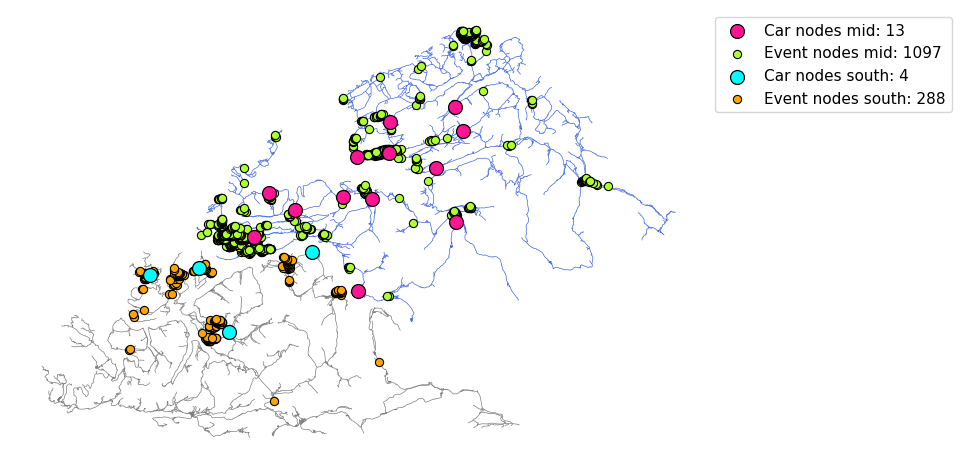

In [99]:
# Plot overview of Car nodes and Event nodes - in the mid and southern network parts
fig, ax = plt.subplots(figsize=(9, 9))
edges_mid.plot(ax=ax, linewidth=0.5, color='royalblue', zorder=-1)
edges_south.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
ax.scatter(car_nodes_gdf_mid['x'], car_nodes_gdf_mid['y'], c='deeppink', edgecolor='black', lw=0.90, s=100, label=f"Car nodes mid: {len(car_nodes_gdf_mid)}", zorder=3)
ax.scatter(event_points_gdf_mid['x'], event_points_gdf_mid['y'], c='greenyellow', s=35, edgecolor='black', lw=0.80, label=f"Event nodes mid: {len(event_points_gdf_mid)}", zorder=2)
ax.scatter(car_nodes_gdf_south['x'], car_nodes_gdf_south['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes south: {len(car_nodes_gdf_south)}", zorder=3)
ax.scatter(event_points_gdf_south['x'], event_points_gdf_south['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes south: {len(event_points_gdf_south)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.axis("off"); plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [100]:
# Creating origins-destination pairs
origins_mid = np.repeat(car_nodes_pdna_mid, len(event_nodes_pdna_mid))
origins_south = np.repeat(car_nodes_pdna_south, len(event_nodes_pdna_south))
destinations_mid = np.tile(event_nodes_pdna_mid, len(car_nodes_pdna_mid))
destinations_south = np.tile(event_nodes_pdna_south, len(car_nodes_pdna_south))

In [101]:
%%time
# travel time between each possible pair of car-event combination - in mid and southern parts
distances_mid = MoreRomsdal_network_pdna_mid.shortest_path_lengths(origins_mid, destinations_mid, imp_name='length')
distances_south = MoreRomsdal_network_pdna_south.shortest_path_lengths(origins_south, destinations_south, imp_name='length')
travel_times_mid = MoreRomsdal_network_pdna_mid.shortest_path_lengths(origins_mid, destinations_mid, imp_name='travel_time')
travel_times_south = MoreRomsdal_network_pdna_south.shortest_path_lengths(origins_south, destinations_south, imp_name='travel_time')
print(f"{len(car_nodes_pdna_mid)+len(car_nodes_pdna_south)} origins x {len(event_nodes_pdna_mid)+len(event_nodes_pdna_south)} destinations = {len(origins_mid)+len(origins_south)} origin-destination pairs (problem size)")
print("(Not a direct cross-join here, since working with multiple disconnected graphs)\n")
print("5 first origin-destination distances (mid) [m]     :", distances_mid[:5])
print("5 first origin-destination travel times (mid) [sec]:", travel_times_mid[:5])

17 origins x 1385 destinations = 15413 origin-destination pairs (problem size)
(Not a direct cross-join here, since working with multiple disconnected graphs)

5 first origin-destination distances (mid) [m]     : [219748.982, 212053.336, 212274.893, 195226.994, 195633.661]
5 first origin-destination travel times (mid) [sec]: [11034.998, 10812.198, 10838.798, 9808.499, 9902.099]
CPU times: total: 406 ms
Wall time: 67 ms


In [102]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times_mid) / 60 # in minutes
travel_times_df.describe().T

count    mean    std   min    25%    50%     75%     max
0 14261.000 117.467 79.483 0.000 43.338 96.413 198.872 264.218

In [103]:
# Restructure the distances and travel times arrays into a DataFrame (CSouthWest Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix_mid = pd.DataFrame({'distance': distances_mid, 'travel_time': travel_times_mid})
CostMatrix_south = pd.DataFrame({'distance': distances_south, 'travel_time': travel_times_south})

# add the car and event node ids as columns
CostMatrix_mid['carNodeID'] = np.repeat(car_nodes_pdna_mid, len(event_nodes_pdna_mid))
CostMatrix_mid['eventNodeID'] = np.tile(event_nodes_pdna_mid, len(car_nodes_pdna_mid))
CostMatrix_south['carNodeID'] = np.repeat(car_nodes_pdna_south, len(event_nodes_pdna_south))
CostMatrix_south['eventNodeID'] = np.tile(event_nodes_pdna_south, len(car_nodes_pdna_south))
# CostMatrix.head() # distances, travel times, car and event node ids

# add the mid and south to a total CostMatrix
CostMatrix = pd.concat([CostMatrix_mid, CostMatrix_south], axis=0)
CostMatrix.head(2)

distance  travel_time   carNodeID  eventNodeID
0 219748.982    11034.998  5784445533   3096495457
1 212053.336    10812.198  5784445533   7389962699

In [104]:
# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time   carNodeID  eventNodeID          x           y
0 219748.982    11034.998  5784445533   3096495457 361607.327 6923274.028
1 212053.336    10812.198  5784445533   7389962699 365855.362 6924241.138

In [105]:
# Save cMoreRomsdal matrix to CSV
CostMatrix.to_csv("../data/MoreRomsdal/MoreRomsdalCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [106]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time   carNodeID   eventNodeID
0    11034.998  5784445533  3096495457_1
1    10812.198  5784445533  7389962699_1

In [107]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
# margin = len(event_nodes_pdna) * 0.05 # 5% of all events
# CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
CAR_CAPACITY = 600
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 600 events per car
Filtering out 0% highest travel times - keeping only travel times <= 15853 sec, or 264.2 min
Original nr of pairs: 15413 | Filtered nr of pairs: 15413
Original max travel time: 15853.099 | Filtered max travel time: 15853.099


### 5.2 Setup LP problem

In [108]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 17
Number of events: 1385


Number of decision variables: 15430
Number of constraints: 16816
Number of non-zero coefficients: 15430
Number of non-zero coefficients in the objective function: 15412
CPU times: total: 609 ms
Wall time: 848 ms


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).

In [109]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
PULP_CBC_CMD with LP relaxation found 3/4 locations in 2.03 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 547.35 seconds: [7389961200 7036804551 7255401621 5849199905]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 1941427.2610 seconds, or 32357.12 minutes, or 539.29 hours
CPU times: total: 1.52 s
Wall time: 9min 10s


### 5.6 Extract results for inspection

In [110]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/MoreRomsdal/MoreRomsdalCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([7389961200, 7036804551, 7255401621, 5849199905])
Car 7389961200 is assigned 600/600 events
Car 7036804551 is assigned 260/600 events
Car 7255401621 is assigned 237/600 events
Car 5849199905 is assigned 288/600 events
Summing the events for each car gives 1385 events, which should equal the total number of unique events: 1385


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 18 | Optimal locations in solution: 4
- Events: 1385 | Max event capacity per police car: 600

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 1941427 sec | 32357.1 min | 539.29 hours

Car id: 7389961200 handles 600 events | Capacity: 100.00% | Total response time: 7542.26 min | Median: 9.71 min | Avg: 12.57 min
Car id: 7036804551 handles 260 events | Capacity: 43.33% | Total response time: 11902.25 min | Median: 31.71 min | Avg: 45.78 min
Car id: 7255401621 handles 237 events | Capacity: 39.50% | Total response time: 2239.44 min | Median: 6.38 min | Avg: 9.45 min
Car id: 5849199905 handles 288 events | Capacity: 48.00% | Total response time: 10673.17 min | Median: 33.03 min | Avg: 37.06 min


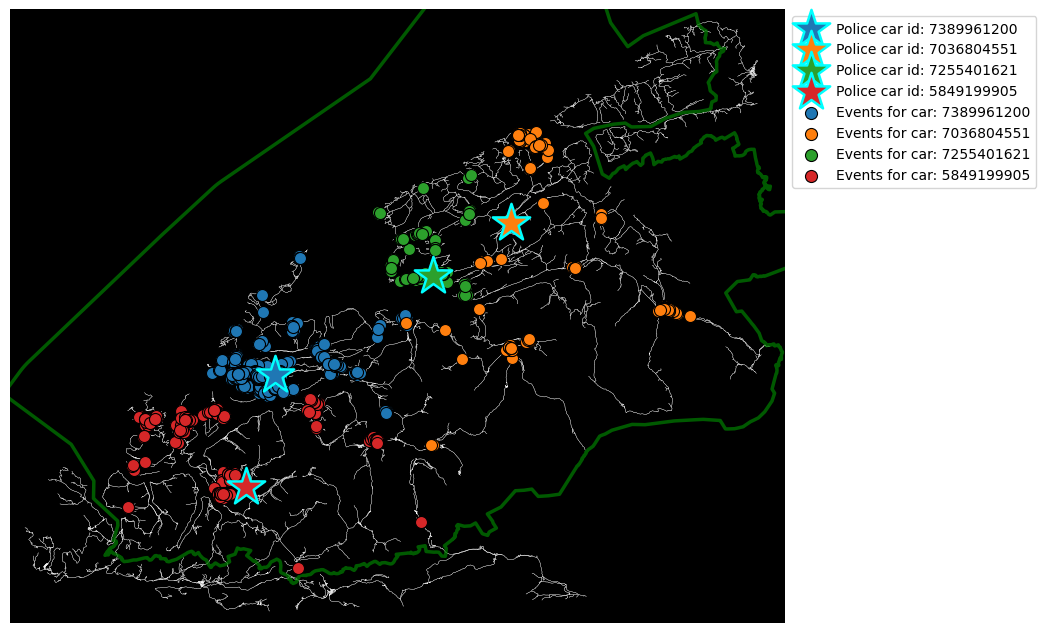

CPU times: total: 2.95 s
Wall time: 3.82 s


In [111]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(MoreRomsdal_graph, MoreRomsdal_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                        car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [116]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 100]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [117]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(MoreRomsdal_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=350, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 38.2 s
Wall time: 47.6 s


Isochrone polygons for the travel times: [20, 60, 100] minutes


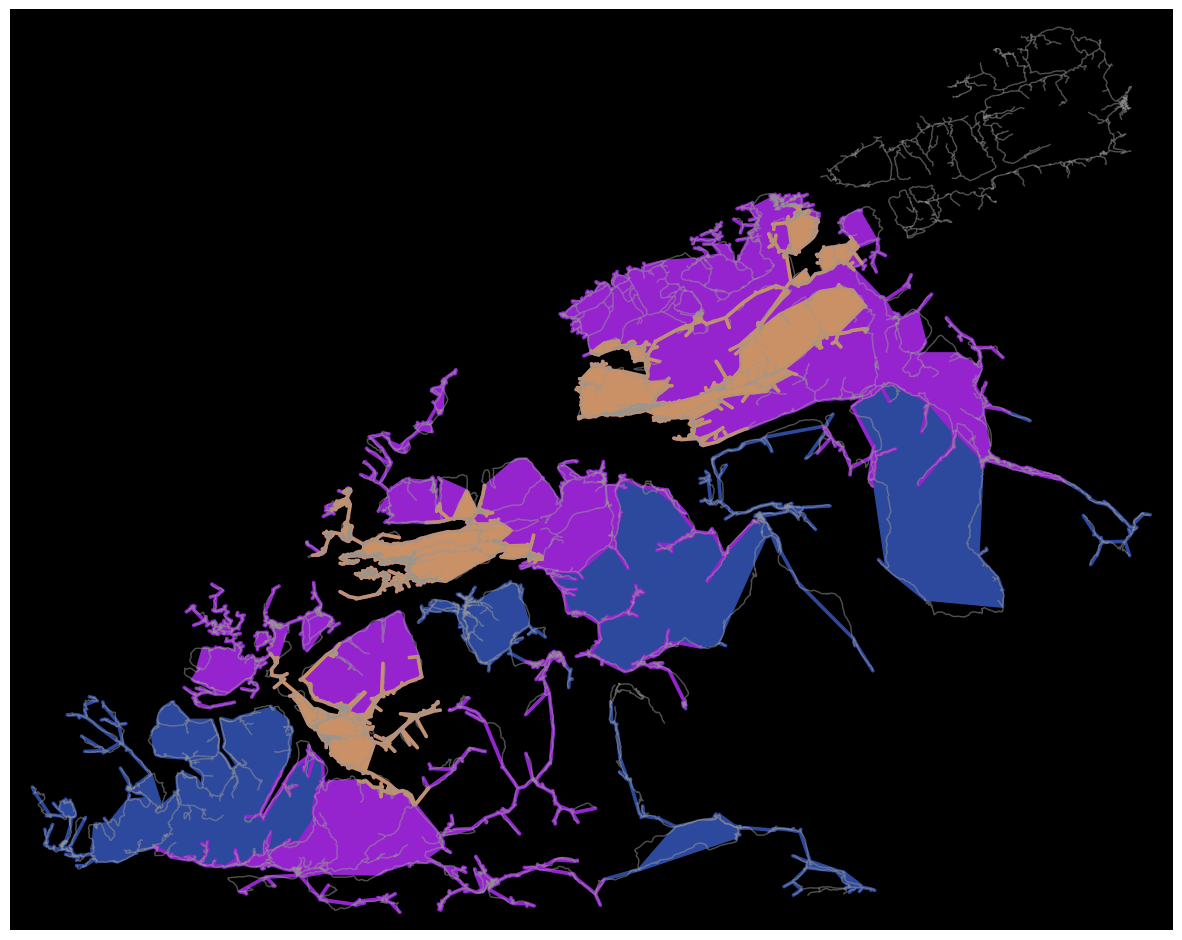

In [118]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(MoreRomsdal_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [119]:
%%time
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(MoreRomsdal_graph_increased, TRIP_TIMES, merged_isochrones, MoreRomsdal_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 703 ms
Wall time: 1.26 s
